<a href="https://colab.research.google.com/github/nkharlamova/ML/blob/main/HW_9_decision_tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Train a classifier on the dataset using DecisionTreeClassifier**

https://archive.ics.uci.edu/ml/datasets/credit+approval


**Complete all stages (preparation, graphical analysis, new features...)**

**Additionally, compare with LogisticRegression and a metric model.**







In [ ]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

import seaborn as sns
import matplotlib.pyplot as plt


**Loading the dataset**

In [ ]:
# Завантажимо наш датасет
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/credit-screening/crx.data"
column_names = [
    "A" + str(i) for i in range(1, 16)
] + ["target"]
df = pd.read_csv(url, names=column_names, na_values='?', skipinitialspace=True)
df.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,target
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,202.0,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,43.0,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,280.0,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,100.0,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,120.0,0,+


**There are categorical features. Let's take a look at additional information for all columns and check for any missing values.**

In [ ]:
# Бачимо, що є категоріальні фічі, дивимось додатково інформацію по всіх колонках і перевіряємо чи є пропущені значення
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A1      678 non-null    object 
 1   A2      678 non-null    float64
 2   A3      690 non-null    float64
 3   A4      684 non-null    object 
 4   A5      684 non-null    object 
 5   A6      681 non-null    object 
 6   A7      681 non-null    object 
 7   A8      690 non-null    float64
 8   A9      690 non-null    object 
 9   A10     690 non-null    object 
 10  A11     690 non-null    int64  
 11  A12     690 non-null    object 
 12  A13     690 non-null    object 
 13  A14     677 non-null    float64
 14  A15     690 non-null    int64  
 15  target  690 non-null    object 
dtypes: float64(4), int64(2), object(10)
memory usage: 86.4+ KB


**Checking how many missing values there are in each column**

In [ ]:
# Дивимося скільки всього пропущених значень по колонках
df.isnull().sum()

A1        12
A2        12
A3         0
A4         6
A5         6
A6         9
A7         9
A8         0
A9         0
A10        0
A11        0
A12        0
A13        0
A14       13
A15        0
target     0
dtype: int64

**We see that there are relatively few missing values overall (about 5% of the total number of rows), so we can delete them**

In [ ]:
# Бачимо, що загалом пропущених значень відносно кількості рядків небагато (близько 5%), тож можемо їх видалити
df_cleaned = df.dropna()
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 653 entries, 0 to 689
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A1      653 non-null    object 
 1   A2      653 non-null    float64
 2   A3      653 non-null    float64
 3   A4      653 non-null    object 
 4   A5      653 non-null    object 
 5   A6      653 non-null    object 
 6   A7      653 non-null    object 
 7   A8      653 non-null    float64
 8   A9      653 non-null    object 
 9   A10     653 non-null    object 
 10  A11     653 non-null    int64  
 11  A12     653 non-null    object 
 12  A13     653 non-null    object 
 13  A14     653 non-null    float64
 14  A15     653 non-null    int64  
 15  target  653 non-null    object 
dtypes: float64(4), int64(2), object(10)
memory usage: 86.7+ KB


**Let's build a scatter plot matrix to examine the distribution and relationships between numerical features**

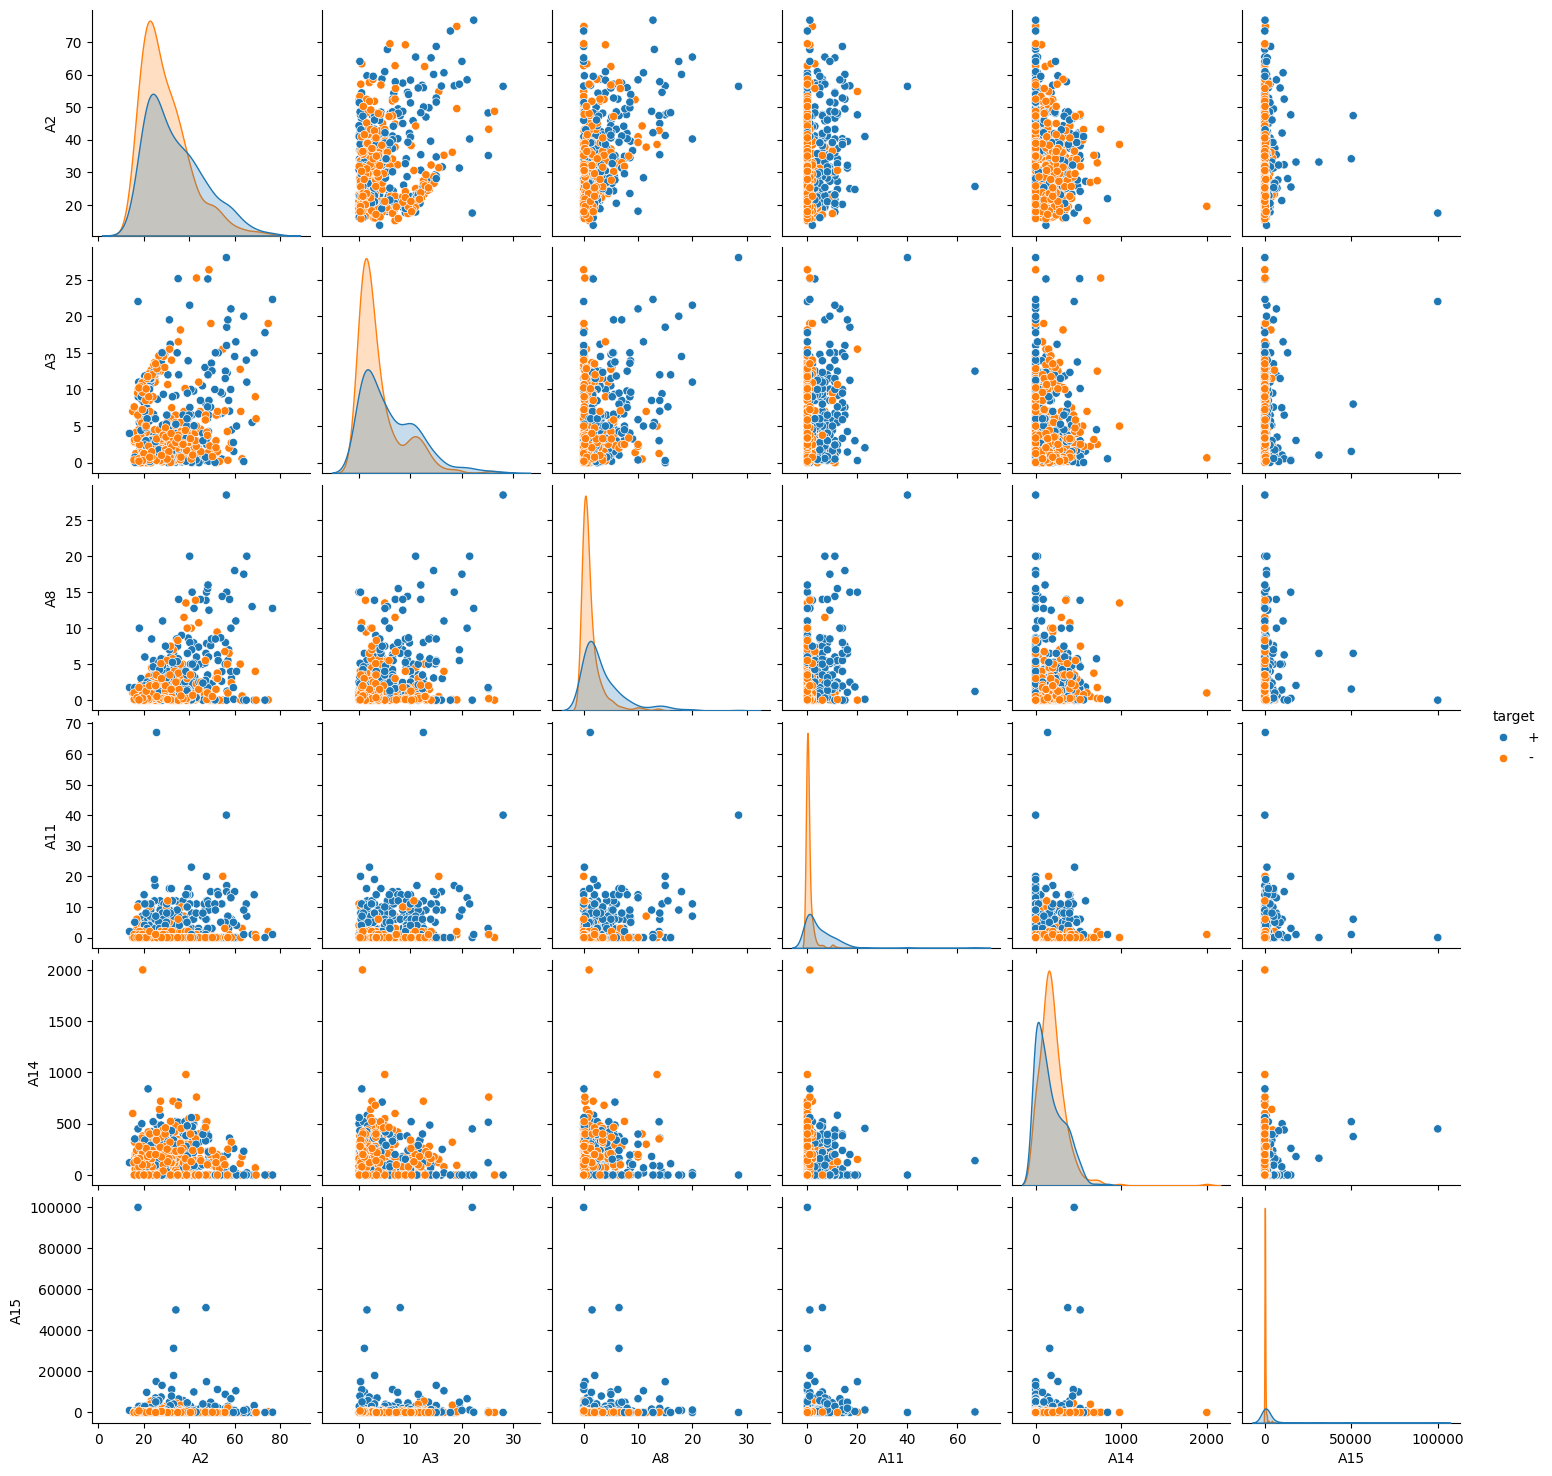

In [ ]:
# Побудуємо матрицю розсіювання, подивимось на розподіл і взаємозв'язки між числовими фічами.
sns.pairplot(df_cleaned, hue="target")
plt.grid(True)
plt.show()

**From the graphs, it's apparent that the values of features A8, A11 and A15 differ significantly between positive and negative outcomes.**

In [ ]:
# З графіків видно, що значення фіч А8, А11 та А15 для позитивного і негативного рішення значно відрізняються

**Let’s make sure of this by looking at their mean values**

In [ ]:
# Перевіримо це, подивившись додатково їх середні значення
numeric_columns = df_cleaned.select_dtypes(include=["float64", "int64"]).columns
df_cleaned[numeric_columns].groupby(df_cleaned["target"]).mean()

,A2,A3,A8,A11,A14,A15
target,,,,,,
+,33.845473,5.971943,3.475186,4.716216,164.621622,2009.726351
-,29.562269,3.882325,1.223725,0.666667,193.408964,187.974790


**Yes, indeed, the difference is significant, especially in A11 and A15**

In [ ]:
# Так, дійсно різниця велика, особливо в А11 та А15

**Let's also look at boxplots**

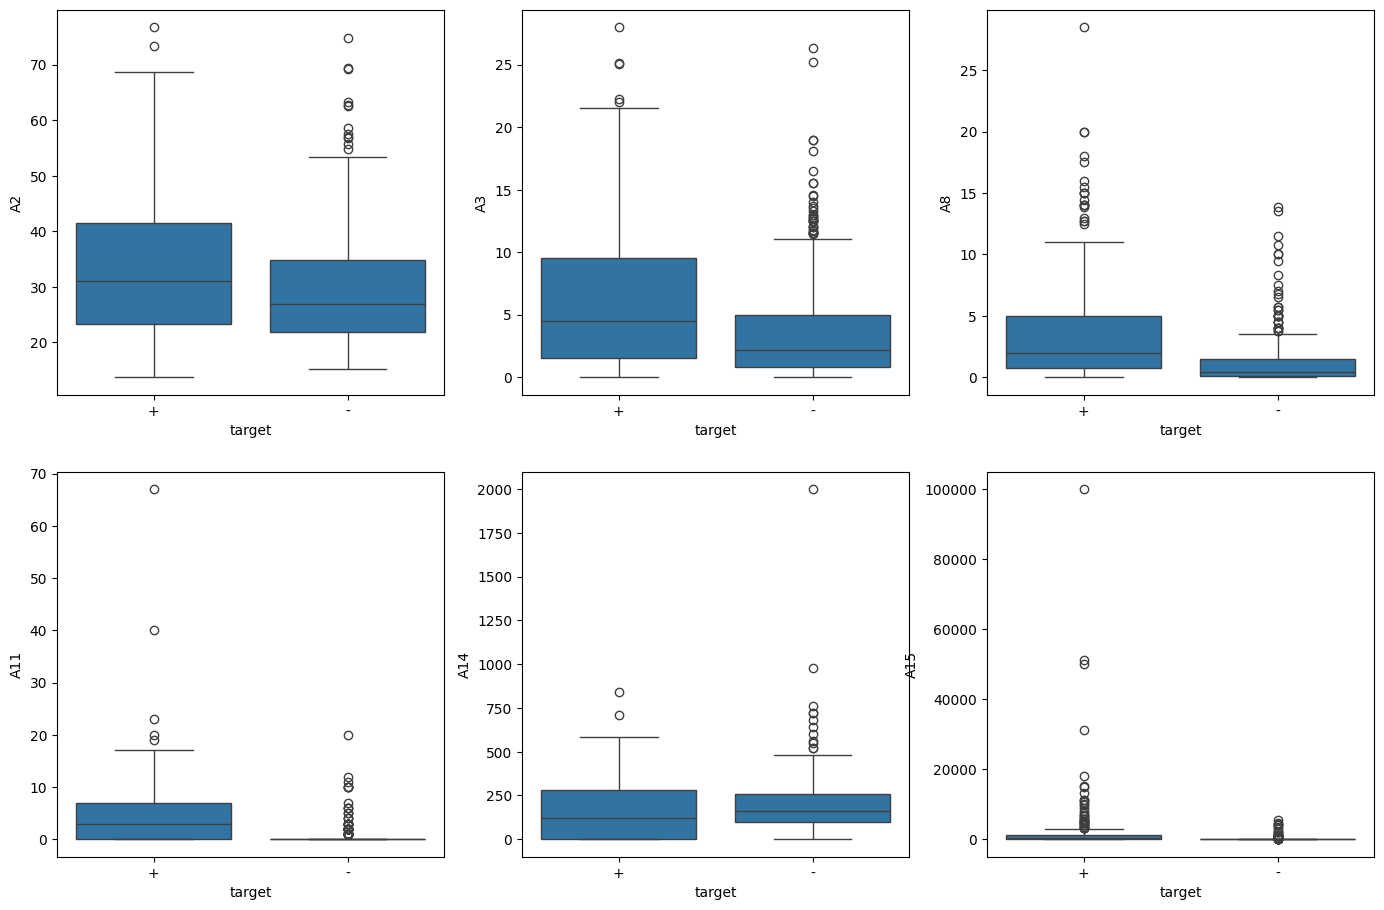

In [ ]:
# Подивимося ще боксплоти
fig, axes = plt.subplots(2, 3,figsize=(17,11))
i = 0
for row in range(2):
    for col in range(3):
        ax1 = sns.boxplot(x="target",y=numeric_columns[i],data=df_cleaned,ax=axes[row,col])
        i += 1
plt.show()

**We can conclude that all numerical features, except A14, are fairly good for classifying positive and negative decisions. On the boxplots, it's clear to see the difference in values between (+) and (-). However, A14 values, on the contrary, are very similar.**

In [ ]:
# Можна зробити висновок, що всі числові фічі, окрім А14, досить непогані для класифікації позитивного і негативного рішень,
# на боксплотах добре видно різницю значень (+) та (-), а от показники А14 навпаки дуже близькі

**Let's consider the impact of categorical features on decision-making**

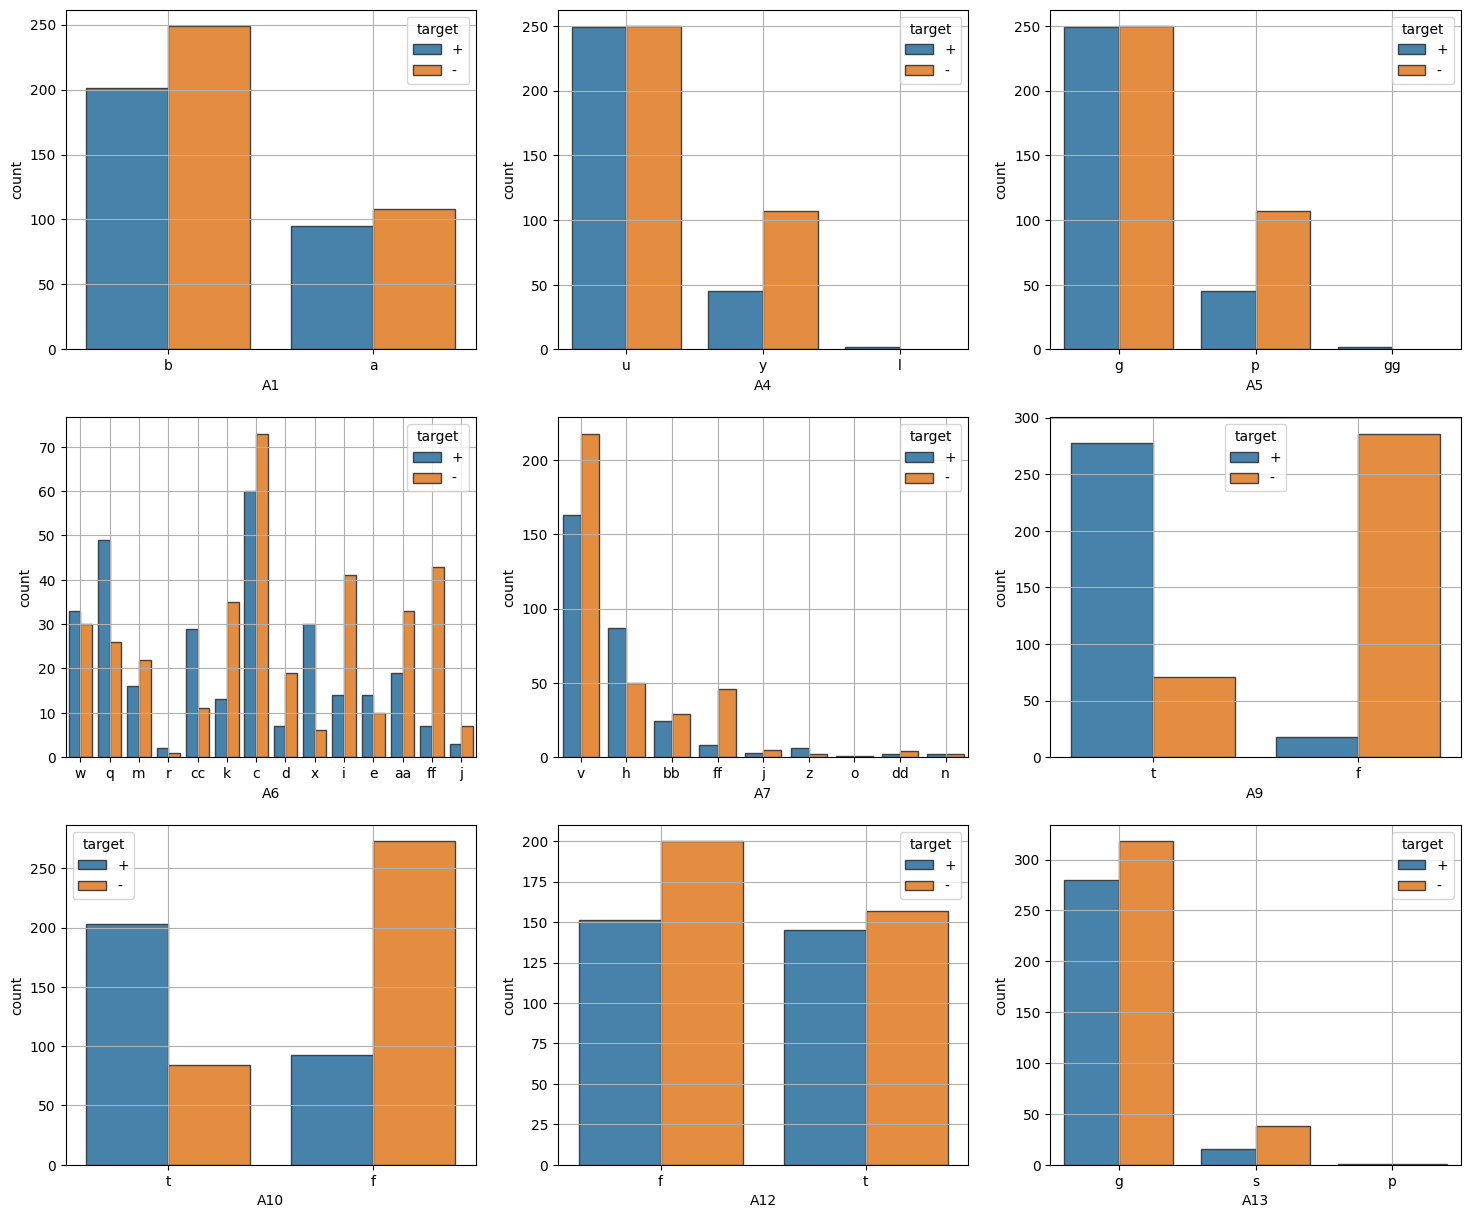

In [ ]:
# Розглянемо тепер вплив категоріальних фіч на прийняття рішень
categorical_columns = df_cleaned.select_dtypes(include=["object"]).columns
fig,axes = plt.subplots(nrows=3, ncols=3, figsize = (18,15))
i = 0
for row in range(3):
    for col in range(3):
        ax = sns.countplot(x=categorical_columns[i], hue="target", data=df_cleaned, edgecolor="0.2", alpha=0.9, ax=axes[row,col])
        ax.grid(True)
        i +=1
plt.show()

**For classification, the best-looking features appear to be A6, A9, and A10, and possibly partially A7, as the difference in values between + and - is quite noticeable. Features A4 and A5 look very similar in the graphs, so there is a high probability that these are multicollinear features or the information in the columns is duplicated. We will examine the correlation after encoding categorical features, and we can verify data equality in the next step.**

In [ ]:
# Для класифікації найкращими виглядають фічі А6, А9 та А10, і можливо частково А7, досить добре видно різницю значень між + та -
# Фічі А4 і А5 дуже подібні на графіках, тож є велика ймовірність, що це мультиколініарні фічі або ж інформація в колонках задубльована.
# Кореляцію ми подивимось вже після кодування категоріальних фіч, а однаковість даних можна перевірити наступним кроком

**Let's take a look at the unique values of categorical features**

In [ ]:
# Подивимось на унікальні значення категоріальних фіч
for column in categorical_columns:
    unique_values = df_cleaned[column].unique()
    print(f"Унікальні значення в колонці {column}:\n{unique_values}\n")

Унікальні значення в колонці A1:
['b' 'a']

Унікальні значення в колонці A4:
['u' 'y' 'l']

Унікальні значення в колонці A5:
['g' 'p' 'gg']

Унікальні значення в колонці A6:
['w' 'q' 'm' 'r' 'cc' 'k' 'c' 'd' 'x' 'i' 'e' 'aa' 'ff' 'j']

Унікальні значення в колонці A7:
['v' 'h' 'bb' 'ff' 'j' 'z' 'o' 'dd' 'n']

Унікальні значення в колонці A9:
['t' 'f']

Унікальні значення в колонці A10:
['t' 'f']

Унікальні значення в колонці A12:
['f' 't']

Унікальні значення в колонці A13:
['g' 's' 'p']

Унікальні значення в колонці target:
['+' '-']



**So, the transformed values of real data for clients in columns A4 and A5 still have different encoded values.**

In [ ]:
# Тож, змінені значення реальних даних по клієнтам в колонках А4 та А5 мають все-таки різні закодовані значення

**We can also see that most columns have non-binary values and more than two categorical features, so we will apply the get_dummies method for encoding categorical features**

In [ ]:
# Також бачимо, що в більшості колонок не бінарні значення і мають більше 2х категоріальних ознак,
# тож застосуємо метод get_dummies для кодування категоріальних фіч
df_encoded = pd.get_dummies(df_cleaned, columns=categorical_columns, drop_first=True)
df_encoded.head()

,A2,A3,A8,A11,A14,A15,A1_b,A4_u,A4_y,A5_gg,...,A7_n,A7_o,A7_v,A7_z,A9_t,A10_t,A12_t,A13_p,A13_s,target_-
0,30.83,0.000,1.25,1,202.0,0,1,1,0,0,...,0,0,1,0,1,1,0,0,0,0
1,58.67,4.460,3.04,6,43.0,560,0,1,0,0,...,0,0,0,0,1,1,0,0,0,0
2,24.50,0.500,1.50,0,280.0,824,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
3,27.83,1.540,3.75,5,100.0,3,1,1,0,0,...,0,0,1,0,1,1,1,0,0,0
4,20.17,5.625,1.71,0,120.0,0,1,1,0,0,...,0,0,1,0,1,0,0,0,1,0


In [ ]:
# Дивимось, що в нас вийшло
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 653 entries, 0 to 689
Data columns (total 38 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   A2        653 non-null    float64
 1   A3        653 non-null    float64
 2   A8        653 non-null    float64
 3   A11       653 non-null    int64  
 4   A14       653 non-null    float64
 5   A15       653 non-null    int64  
 6   A1_b      653 non-null    uint8  
 7   A4_u      653 non-null    uint8  
 8   A4_y      653 non-null    uint8  
 9   A5_gg     653 non-null    uint8  
 10  A5_p      653 non-null    uint8  
 11  A6_c      653 non-null    uint8  
 12  A6_cc     653 non-null    uint8  
 13  A6_d      653 non-null    uint8  
 14  A6_e      653 non-null    uint8  
 15  A6_ff     653 non-null    uint8  
 16  A6_i      653 non-null    uint8  
 17  A6_j      653 non-null    uint8  
 18  A6_k      653 non-null    uint8  
 19  A6_m      653 non-null    uint8  
 20  A6_q      653 non-null    uint8 

**Let's take a look at the correlation matrix**

<Axes: >

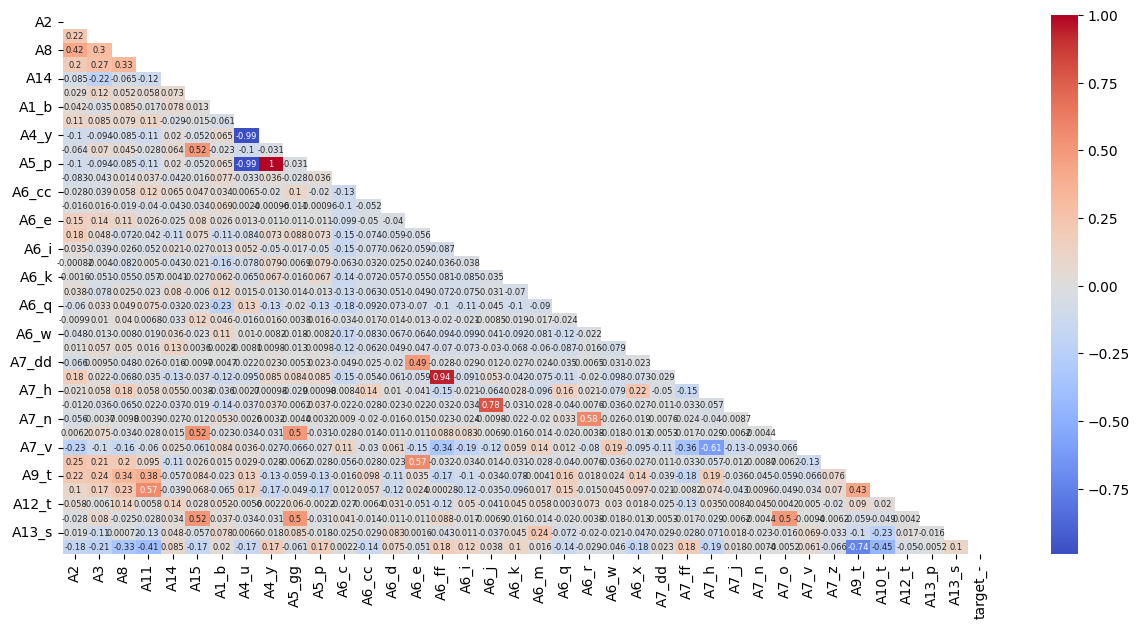

In [ ]:
# Подивимося тепер матрицю кореляцій
corr_df = df_encoded.corr(numeric_only=True)
plt.figure(figsize=(15, 7))
matrix = np.triu(corr_df.corr())
sns.heatmap(corr_df, cmap="coolwarm", annot=True, annot_kws={"fontsize":6}, center= 0, mask=matrix)

**We can see that our assumption about multicollinearity between columns A4 and A5 is confirmed; some of their metrics show very high correlation. Additionally, there is a significant correlation between A6_ff and A7_h. Since we have just a few of these 'issues,' we won't delete anything**

In [ ]:
# Бачимо, що наше припущення щодо мультиколініарності А4 та А5 підтвердилось, деякі їх показники мають дуже високу кореляцію.
# Також маємо великий показник кореляції між А6_ff та A7_h. Так як таких "проблем" в нас буквально декілька, не будемо нічого видаляти

**Adding a new feature - the average value of the numerical columns**

In [ ]:
# Додамо нову фічу - середнє значення числових колонок
df_encoded["A_num_mean"] = df_encoded.iloc[:, 1:15].mean(axis=1)

**Splitting the dataset into a feature matrix**

In [ ]:
# Розділяємо датасет на матрицю фіч
X = df_encoded.drop("target_-", axis=1)
y = df_encoded["target_-"]

**Scaling the features**

In [ ]:
# Масштабуємо фічі
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

**Splitting the dataset into training, validation, and test samples**

In [ ]:
# Розділяємо датасет на тренувальну, валідаційну та тестову частини
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

**Creating DecisionTreeClassifier model**

In [ ]:
# Створюємо модель DecisionTreeClassifier
dtc_model = DecisionTreeClassifier(random_state=42, max_depth=6)
dtc_model.fit(X_train, y_train)
y_pred_dt = dtc_model.predict(X_test)

**GridSearch parameters**

In [ ]:
# tuning the parameters:
# Підбираємо параметри
param_grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": [3, 4, 5, 6, 7, 8],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

# creating a grid_search object and train it on the validation data:
# Створюємо об'єкт grid_search та навчаємо його на валідаційних даних:
grid_search = GridSearchCV(estimator=dtc_model, param_grid=param_grid, cv=5, scoring="accuracy")
grid_search.fit(X_val, y_val)

# obtaining the best parameters and the best model:
# Отримуємо найкращі параметри і найкращу модель
best_params = grid_search.best_params_
best_dtc_model = grid_search.best_estimator_
print("Best Parameters:", best_params)

# evaluating on the validation data:
# Оцінюємо на валідаційних даних
valid_accuracy = best_dtc_model.score(X_val, y_val)
print("Validation Accuracy:", valid_accuracy)

Best Parameters: {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 10}
Validation Accuracy: 0.9285714285714286


**Decision Tree Visualisation**

[Text(0.49255952380952384, 0.9285714285714286, 'x[32] <= -0.069\ngini = 0.496\nsamples = 100.0%\nvalue = [0.453, 0.547]'),
 Text(0.24404761904761904, 0.7857142857142857, 'x[9] <= 8.993\ngini = 0.074\nsamples = 45.7%\nvalue = [0.038, 0.962]'),
 Text(0.22023809523809523, 0.6428571428571429, 'x[23] <= 1.949\ngini = 0.065\nsamples = 45.5%\nvalue = [0.034, 0.966]'),
 Text(0.15476190476190477, 0.5, 'x[28] <= 6.33\ngini = 0.057\nsamples = 45.1%\nvalue = [0.029, 0.971]'),
 Text(0.09523809523809523, 0.35714285714285715, 'x[4] <= 1.458\ngini = 0.048\nsamples = 44.4%\nvalue = [0.025, 0.975]'),
 Text(0.047619047619047616, 0.21428571428571427, 'x[12] <= 1.83\ngini = 0.031\nsamples = 41.6%\nvalue = [0.016, 0.984]'),
 Text(0.023809523809523808, 0.07142857142857142, 'gini = 0.022\nsamples = 39.4%\nvalue = [0.011, 0.989]'),
 Text(0.07142857142857142, 0.07142857142857142, 'gini = 0.18\nsamples = 2.2%\nvalue = [0.1, 0.9]'),
 Text(0.14285714285714285, 0.21428571428571427, 'x[1] <= -0.717\ngini = 0.26\nsam

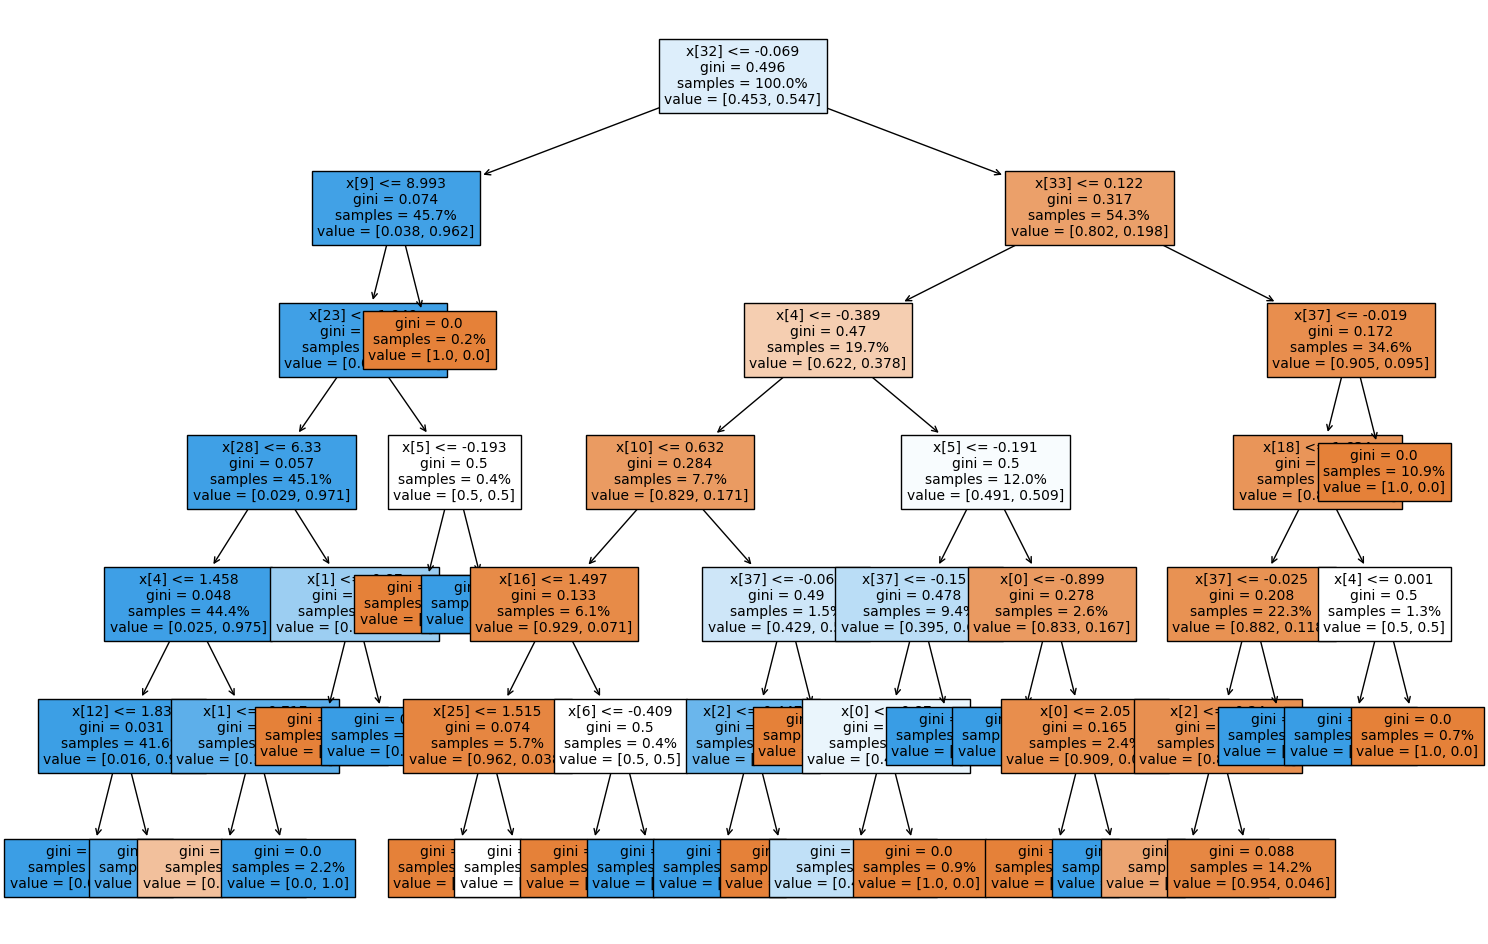

In [ ]:
# Візуалізуємо наше дерево
plt.figure(figsize=(18,12))
tree.plot_tree(dtc_model,filled=True,
               fontsize=10,
               proportion=True)

**We can see that the root of the tree is column A9. Let's take a look at the importance of each feature**

In [ ]:
# Бачимо, що корінь дерева в нас це колонка А9
# Подивимося на важливість кожної ознаки
feature_importance = dtc_model.feature_importances_
for feature, importance in zip(X.columns, feature_importance):
    print(f"{feature}: {importance}")

A2: 0.03160612275247612
A3: 0.018316692011313338
A8: 0.016432448646693184
A11: 0.0
A14: 0.045140276857381846
A15: 0.024890998575397037
A1_b: 0.005411749912433487
A4_u: 0.0
A4_y: 0.0
A5_gg: 0.01005889345842044
A5_p: 0.015152899754813752
A6_c: 0.0
A6_cc: 0.0008101801038497442
A6_d: 0.0
A6_e: 0.0
A6_ff: 0.0
A6_i: 0.004281824106540781
A6_j: 0.0
A6_k: 0.008966526815698619
A6_m: 0.0
A6_q: 0.0
A6_r: 0.0
A6_w: 0.0
A6_x: 0.004753468533055091
A7_dd: 0.0
A7_ff: 0.004995461457630917
A7_h: 0.0
A7_j: 0.0
A7_n: 0.0030492911968539108
A7_o: 0.0
A7_v: 0.0
A7_z: 0.0
A9_t: 0.7167990881505488
A10_t: 0.04964786413416005
A12_t: 0.0
A13_p: 0.0
A13_s: 0.0
A_num_mean: 0.039686213532732925


**This feature (А9) is the most important for the dataset**

In [ ]:
# Ця ж ознака є найважливішою для датасету

**Creating LogisticRegression Model**

In [ ]:
# creating a LogisticRegression model:
# Створюємо модель LogisticRegression
log_reg_model = LogisticRegression(random_state=42)
log_reg_model.fit(X_train, y_train)
y_pred_log_reg = log_reg_model.predict(X_test)

# cross-validation:
# Робимо крос-валідацію:
cv_scores = cross_val_score(log_reg_model, X_train, y_train, cv=5)

# calculating the evaluation on the training and test samples:
# Розраховуємо оцінку на тренувальній та тестовій вибірці:
train_score = log_reg_model.score(X_train, y_train)
test_score = log_reg_model.score(X_test, y_test)

# print the scores:
# Дивимося оцінку по фолдам а також по тренувальній та тестовій виборкам:
print("Cross-Validation Scores:", cv_scores)
print("Train Score:", train_score)
print("Test Score:", test_score)

Cross-Validation Scores: [0.89130435 0.86956522 0.85714286 0.87912088 0.9010989 ]
Train Score: 0.9102844638949672
Test Score: 0.8673469387755102


**The evaluations on the training and test samples show normal metrics, with a small gap between them. We can conclude that the logistic regression model generalizes the data well and is fairly stable. Additionally, we have good metrics from cross-validation**

In [ ]:
# Оцінки на тренувальній та тестовій виборках мають нормальні показники, розрив між ними невеликий.
# Можемо зробити висновок, що наша модель логістичної регресії добре узагальнює дані
# і є достатньо стабільна.
# Також гарні показники по кросс-валідації

**Creating K-Nearest Neighbors model**

In [ ]:
# creating a K-Nearest Neighbors model:
# Створюємо метричну модель (K-Nearest Neighbors)
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)

# cross-validation:
# Робимо крос-валідацію:
cv_scores = cross_val_score(knn_model, X_train, y_train, cv=5)

# calculating the evaluation on the training and test samples:
# Розраховуємо оцінку на тренувальній та тестовій вибірці:
train_score = knn_model.score(X_train, y_train)
test_score = knn_model.score(X_test, y_test)

# print the scores:
# Дивимося оцінку по фолдам а також по тренувальній та тестовій виборкам:
print("Cross-Validation Scores:", cv_scores)
print("Train Score:", train_score)
print("Test Score:", test_score)

Cross-Validation Scores: [0.79347826 0.7826087  0.83516484 0.79120879 0.82417582]
Train Score: 0.8599562363238512
Test Score: 0.8163265306122449


**The K-Nearest Neighbors model also shows quite good metrics. We may just look at the standard deviation of the scores from cross-validation**

In [ ]:
# В моделі K-Nearest Neighbors також досить гарні показники,
# можна тільки додатково подивитися на стандартне відхилення оцінок по нашій кросс-валідації
std_deviation = np.std(cv_scores)
print(f"Standard deviation of cv-scores: {std_deviation}")

Standard deviation of cv-scores: 0.020500792036566556


**We have a normal value**

In [ ]:
# Абсолютно нормальне значення, тож йдемо далі

**Let's take a look at the performance metrics of the DecisionTreeClassifier model**

In [ ]:
# Подивимось оцінки продуктивності моделі DecisionTreeClassifier
accuracy_dtc = accuracy_score(y_test, y_pred_dt)
report_dtc = classification_report(y_test, y_pred_dt)
print("DecisionTreeClassifier:")
print(f"Accuracy: {accuracy_dtc:.2f}")
print("Classification Report:")
print(report_dtc)

DecisionTreeClassifier:
Accuracy: 0.87
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.86      0.87        51
           1       0.85      0.87      0.86        47

    accuracy                           0.87        98
   macro avg       0.87      0.87      0.87        98
weighted avg       0.87      0.87      0.87        98



**Let's take a look at the performance metrics of the LogisticRegression model**

In [ ]:
# Подивимось оцінки продуктивності моделі LogisticRegression
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
report_log_reg = classification_report(y_test, y_pred_log_reg)
print("\nLogisticRegression:")
print(f"Accuracy: {accuracy_log_reg:.2f}")
print("Classification Report:")
print(report_log_reg)


LogisticRegression:
Accuracy: 0.87
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.86      0.87        51
           1       0.85      0.87      0.86        47

    accuracy                           0.87        98
   macro avg       0.87      0.87      0.87        98
weighted avg       0.87      0.87      0.87        98



**Let's take a look at the performance metrics of the K-Nearest Neighbors model**

In [ ]:
# Подивимось оцінки продуктивності моделі K-Nearest Neighbors
accuracy_knn = accuracy_score(y_test, y_pred_knn)
report_knn = classification_report(y_test, y_pred_knn)
print("\nK-Nearest Neighbors:")
print(f"Accuracy: {accuracy_knn:.2f}")
print("Classification Report:")
print(report_knn)


K-Nearest Neighbors:
Accuracy: 0.82
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.76      0.81        51
           1       0.77      0.87      0.82        47

    accuracy                           0.82        98
   macro avg       0.82      0.82      0.82        98
weighted avg       0.82      0.82      0.82        98



**CONCLUSION: According to the performance metrics across three models, we see that the DecisionTreeClassifier and LogisticRegression models perform similarly. Therefore, we can conclude that both models handle the classification task well in the dataset, and there is no significant difference in their performance. The K-Nearest Neighbors model has slightly lower scores, indicating slightly worse performance. Additionally, tuning hyperparameters for the DecisionTree model resulted in the highest accuracy score, nearly 93%**

In [ ]:
# Згідно з оцінками продуктивності по 3м моделям, бачимо, що показники DecisionTreeClassifier та LogisticRegression однакові,
# тож можна зробити висновок, що обидві моделі добре справляються з задачею класифікації даних в нашому датасеті
# і суттєвої різниці в їх продуктивності немає.
# Модель K-NearestNeighbors має дещо нижчі оцінки, а значить і продуктивність її трохи гірша.
# Також підбір гіперпараметрів до моделі DecisionTree дав найбільший показник accuracy - майже 93%.